In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
import simulation
import matplotlib.pyplot as plt
from aughs import ShrinkageClassifier, cross_val_lmb
from tqdm import trange, tqdm

In [2]:
N_REPLICATIONS = 1
LAMBDAS = np.arange(0, 100, 5)
#LAMBDAS = [1.]

In [4]:
result = {}
for relevance in tqdm([0., 0.05, 0.1, 0.15, 0.2]):
    importances = {
        key: np.zeros((N_REPLICATIONS, 5))
        for key in ["Random Forest", "Hierarchical Shrinkage", "HS: Entropy",
                    "HS: Entropy (2)", "HS: log cardinality"]
    }
    for i in range(N_REPLICATIONS):
        X, y = simulation.simulate_categorical(1000, relevance)
        
        # Compute importances for classical RF
        rfc = DecisionTreeClassifier().fit(X, y)
        importances["Random Forest"][i, :] = rfc.feature_importances_

        # Compute importances for different HS modes
        hsc = ShrinkageClassifier(DecisionTreeClassifier())
        for shrink_mode, key in zip(["hs", "hs_entropy", "hs_entropy_2", "hs_log_cardinality"],
                                    ["Hierarchical Shrinkage", "HS: Entropy", "HS: Entropy (2)", "HS: log cardinality"]):
            """
            gs = GridSearchCV(ShrinkageClassifier(DecisionTreeClassifier(), shrink_mode=shrink_mode),
                                param_grid={"lmb": LAMBDAS}, cv=3, n_jobs=-1)
            gs.fit(X, y)
            hsc = gs.best_estimator_
            importances[key][i, :] = hsc.estimator_.feature_importances_

            """
            lmb_scores = cross_val_lmb(hsc, X, y, shrink_mode, LAMBDAS, n_splits=5)
            best_idx = np.argmax(lmb_scores)
            best_lmb = LAMBDAS[best_idx]
            hsc.lmb = best_lmb
            hsc.shrink_mode = shrink_mode
            hsc.fit(X, y)
            importances[key][i, :] = hsc.estimator_.feature_importances_
    result[relevance] = importances

100%|██████████| 5/5 [00:23<00:00,  4.77s/it]


In [5]:
def plot_importances(result, relevance):
    importances = result[relevance]
    width = 0.1
    for i, key in enumerate(importances.keys()):
        plt.bar(np.arange(5) + (i-2)*width, np.mean(importances[key], axis=0), label=key, width=width)
    plt.legend()
    plt.title(f"Relevance: {relevance}")
    plt.show()

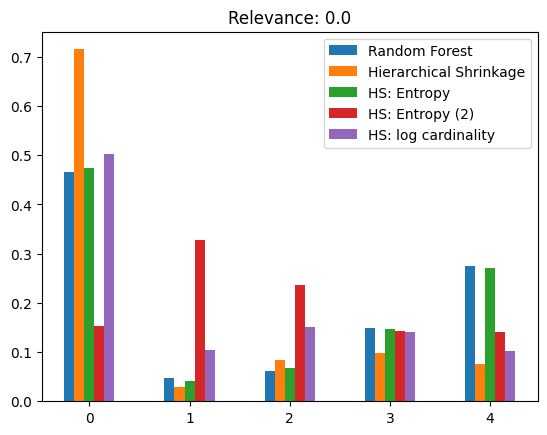

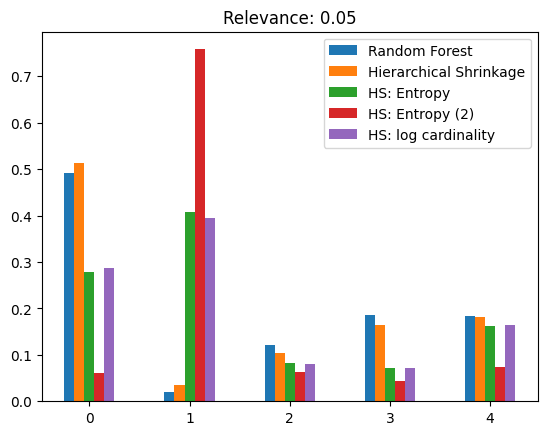

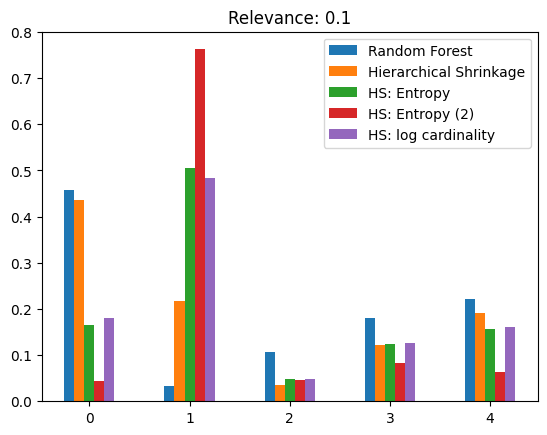

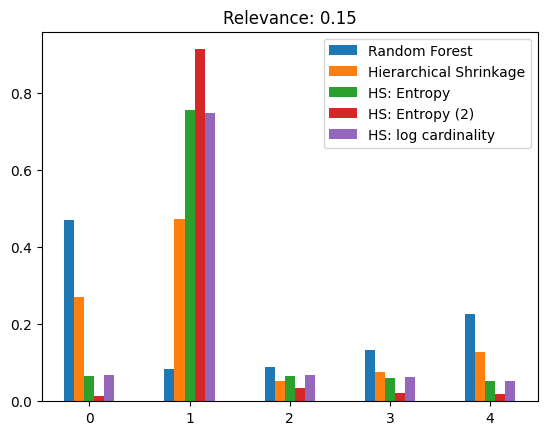

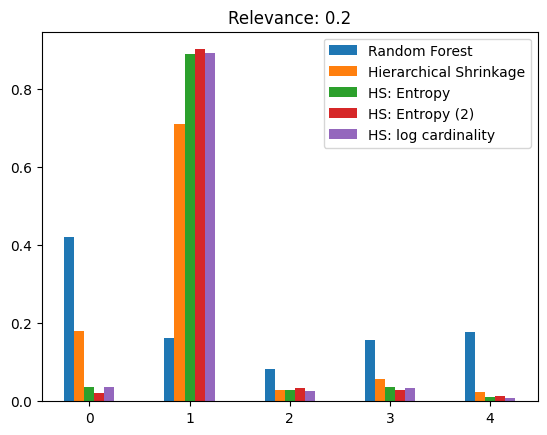

In [6]:
for importance in result:
    plot_importances(result, importance)